# Przetwarzanie Grafiki i Muzyki - laboratorium nr 9: Operacje „Hit-and-Miss” („Hit-or-Miss”)


  * Bazowa operacja morfologii matematycznej.
  * W notebooku będziemy pracować na elementach strukturalnych, które mają następujące elementy:
    * Piksele obiektu ('1')
    * Piksele tła ('0')
    * Piksele nieokreślone – niebrane pod uwagę ('x')

  * Obraz wejściowy jest przeglądany piksel po pikselu, a następnie, jeśli konfiguracja pikseli sąsiednich jest identyczna jak w elemencie strukturalnym (ang. structural element, w skrócie SE), to jest on ustawiany na wartość '1', w przeciwnym przypadku na '0'.
  * Aby wykryć daną cechę, wyniki kilku SE mogą się sumować/mnożyć.
  
  
## Hit-or-miss - w skrócie

  * Przykładamy środek obiektu strukturalnego do każdego piksela obrazka i jeśli pasuje on do sąsiedztwa danego piksela, to zamieniam piksel na biały, a jeśli nie to na czarny.
  * Przydatny link z wyjaśnieniem: https://theailearner.com/tag/hit-or-miss-transformation-opencv/

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Zadanie 1 (2 punkty)
  * Proszę dokonac binaryzacji obrazu LENA_512 algorytmem Otsu.
  * Proszę wykonać operację Hit-or-miss przy pomocy danego elementu strukturalnego:


$$
\begin{bmatrix} 
1 & 1 & 1 \\
1 & x & 1 \\
1 & 1 & 1 \\
\end{bmatrix} 
$$

Hint: Aby wykonać to zadanie, proszę spojrzeć na dokumentację metody morphologyEx(...) z pakietu OpenCV.

In [28]:
image = cv2.imread('./img/LENA_512.jpg', cv2.IMREAD_GRAYSCALE)
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.array([[1, 1, 1],
                   [1, -1, 1],
                   [1, 1, 1]], dtype=np.int8)

hit_or_miss_image = cv2.morphologyEx(binary_image, cv2.MORPH_HITMISS, kernel)

cv2.imshow('Original Image', image)
cv2.imshow('Binary Image', binary_image)
cv2.imshow('Hit-or-Miss Image', hit_or_miss_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


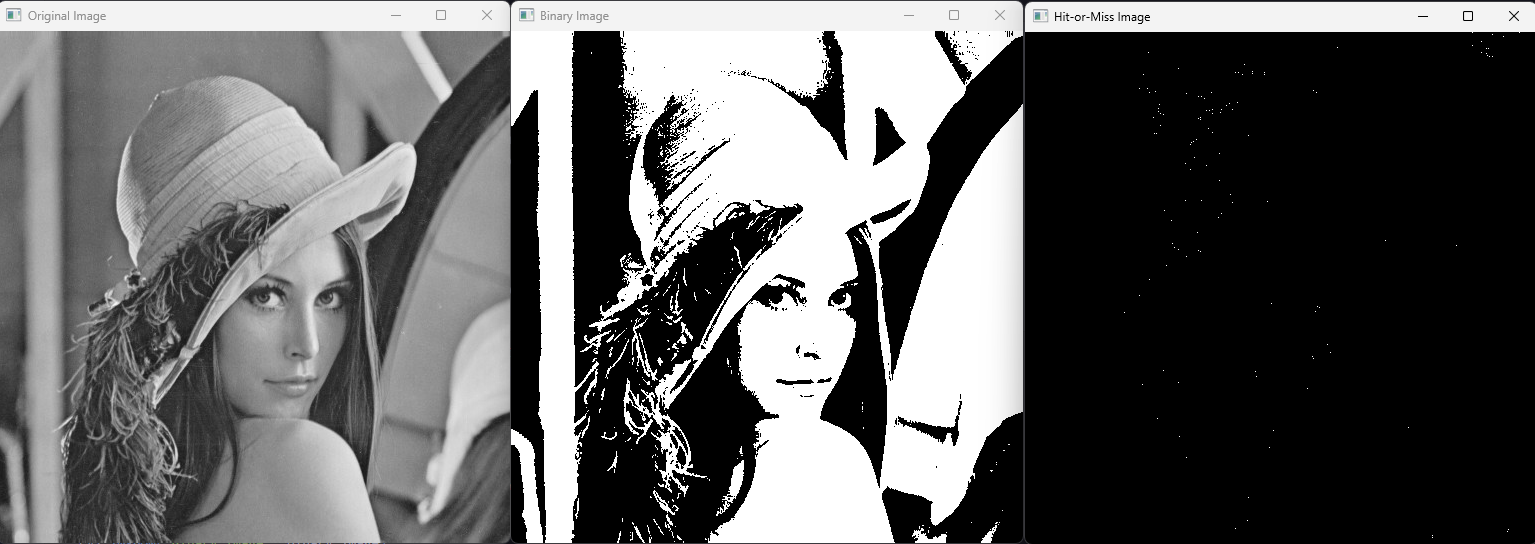

## Operacja pogrubiania – wypukły kształt (convex hull)

Naszym celem jest znalezienie wypukłej otoczki obiektów.

  * Używanych jest 8 SE:
    * 2 wzorcowe:

$$
\begin{bmatrix} 
1 & 1 & x \\
1 & 0 & x \\
1 & x & 0 \\
\end{bmatrix} 
$$

oraz

$$
\begin{bmatrix} 
x & 1 & 1 \\
x & 0 & 1 \\
0 & x & 1
\end{bmatrix} 
$$
  * Po 3 SE z każdego wzorcowego obrócone o 90, 180, 270 stopni.

  * Procedura iteracyjna: po osiągnięciu zbieżności kolejne iteracje nie zmieniają wyniku (procedura zatrzymuje się sama)

In [ ]:
# findCountours(...)
# cv2.convexHull


## Zadanie 2 (4 punkty)

Proszę zbudować otoczkę wypukłą elementów na https://raw.githubusercontent.com/przem85/PGiM/master/img/convex.png. Proszę pokazać efekty skończonej procedury.

HINT: Aby zbudować otoczkę wypukłą na obiekcie, musimy najpierw znaleźć jego kształt!

In [14]:
img = cv2.imread('./img/convex.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    hull = cv2.convexHull(contour)
    img = cv2.drawContours(img, [hull], 0, (0,255,255), 3)

cv2.imshow("Convex Hull", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

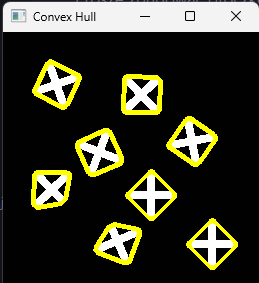

# Operacje pocieniania – znajdowanie szkieletu obiektu

  * Naszym celem jest znalezienie szkieletu obiektu – linii reprezentujących obiekt.

  * iteracyjne zmniejszanie obiektów – 8 SE powstałych z obrotów 2 SE:

$$
\begin{bmatrix} 
1 & 1 & x \\
1 & 0 & x \\
1 & x & 0 \\
\end{bmatrix} 
$$

oraz

$$
\begin{bmatrix} 
x & 1 & 1 \\
x & 0 & 1 \\
0 & x & 1
\end{bmatrix} 
$$

# Zadanie 3 (4 punkty)
Proszę zbudować szkielet powyższą metodą na zbinaryzowanych (algorytmem 0tsu) obrazkach (Uwaga: Obrazki poniżej nie są binarne). Proszę wykonać zadanie na dwóch wybranych obrazkach:

  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template1.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template2.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template3.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template4.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template5.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template6.png.

Proszę pokazać efekty z kilku iteracji.

HINT: Proszę rzucić okiem na ten blog http://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html

In [27]:
import cv2
import numpy as np

def skeleton(img, size, skel):
    done = False
    while(not done):
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True

    cv2.imshow("skel", skel)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

img1 = cv2.imread('./img/template1.png', 0)
img2 = cv2.imread('./img/template2.png', 0)
size1 = np.size(img1)
size2 = np.size(img2)
skel1 = np.zeros(img1.shape, np.uint8)
skel2 = np.zeros(img2.shape, np.uint8)
ret, img1 = cv2.threshold(img1, 127, 255, 0)
ret, img2 = cv2.threshold(img2, 127, 255, 0)
skeleton(img1, size1, skel1)
skeleton(img2, size2, skel2)

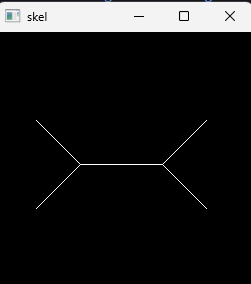

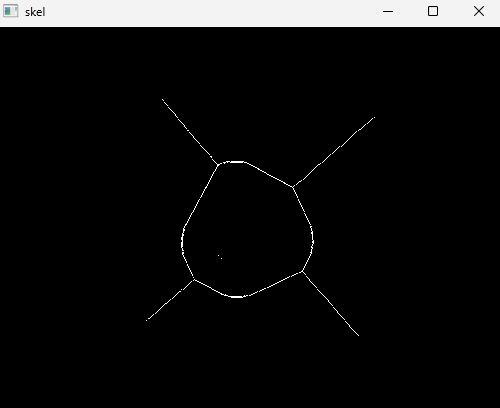